In [1]:
import GPy
from GPy.kern.src.kern import Kern
from GPy.core import Param
from GPy.util.linalg import tdot
from GPy.kern.src.psi_comp import PSICOMP_Linear

from paramz.transformations import Logexp
from paramz.caching import Cache_this

import numpy as np

## Augmented Implementation of Linear Kernel
GPy's `Linear` kernel is simply the scaled dot product of its inputs. The scale shifted kernel is defined as:

$k_{LIN}(x,x') = \sigma_b^{2} + \sigma_v^{2}\left(x - \ell\right)\left(x' - \ell\right)$

In [2]:
class LinScaleShift(Kern):
    """
    Linear kernel

    .. math::

       k(x,y) = \sum_{i=1}^{\\text{input_dim}} \sigma^2_i x_iy_i

    :param input_dim: the number of input dimensions
    :type input_dim: int
    :param variances: the vector of variances :math:`\sigma^2_i`
    :type variances: array or list of the appropriate size (or float if there
                     is only one variance parameter)
    :param ARD: Auto Relevance Determination. If False, the kernel has only one
                variance parameter \sigma^2, otherwise there is one variance
                parameter per dimension.
    :type ARD: Boolean
    :rtype: kernel object

    """

    def __init__(self, input_dim, variances=None, shifts=None, ARD=False, active_dims=None, name='lin'):
        super(LinScaleShift, self).__init__(input_dim, active_dims, name)
        self.ARD = ARD
        if not ARD:
            if variances is not None:
                variances = np.asarray(variances)
                assert variances.size == 1, "Only one variance needed for non-ARD kernel"
            else:
                variances = np.ones(1)
            if shifts is not None:
                shifts = np.asarray(shifts)
                assert shifts.size == 1, "Only one shift needed for non-ARD kernel"
            else:
                shifts = np.ones(1)
        else:
            if variances is not None:
                variances = np.asarray(variances)
                assert variances.size == self.input_dim, "bad number of variances, need one ARD variance per input_dim"
            else:
                variances = np.ones(self.input_dim)
            if shifts is not None:
                shifts = np.asarray(shifts)
                assert shifts.size == self.input_dim, "bad number of shifts, need one ARD shift per input_dim"
            else:
                shifts = np.ones(self.input_dim)

        self.variances = Param('variances', variances, Logexp())
        self.shifts = Param('shifts', shifts, Logexp())
        self.link_parameter(self.variances)
        self.link_parameter(self.shifts)
        self.psicomp = PSICOMP_Linear()

    def to_dict(self):
        input_dict = super(LinScaleShift, self)._save_to_input_dict()
        input_dict["class"] = "GPy.kern.LinScaleShift"
        input_dict["variances"] = self.variances.values.tolist()
        input_dict["shifts"] = self.shifts.values.tolist()
        input_dict["ARD"] = self.ARD
        return input_dict

    @staticmethod
    def _build_from_input_dict(kernel_class, input_dict):
        useGPU = input_dict.pop('useGPU', None)
        return LinScaleShift(**input_dict)

    @Cache_this(limit=3)
    def K(self, X, X2=None):
        X_s = X - self.shifts
        if self.ARD:
            if X2 is None:
                return tdot(X_s*np.sqrt(self.variances))
            else:
                X2_s = X2 - self.shifts
                rv = np.sqrt(self.variances)
                return np.dot(X_s*rv, (X2_s*rv).T)
        else:
            if X2 is None:
                X2_s = X_s
            else:
                X2_s = X2 - self.shifts
            return self._dot_product(X_s, X2_s) * self.variances

    @Cache_this(limit=3, ignore_args=(0,))
    def _dot_product(self, X, X2=None):
        if X2 is None:
            return tdot(X)
        else:
            return np.dot(X, X2.T)

    def Kdiag(self, X):
        return np.sum(self.variances * np.square(X - self.shifts), -1)

    def update_gradients_full(self, dL_dK, X, X2=None):
        X_s = X - self.shifts
        if X2 is None: 
            dL_dK = (dL_dK+dL_dK.T)/2
            X2 = X
            X2_s = X_s
        else:
            X2_s = X2 - self.shifts
        
        if self.ARD:
            if X2 is None:
                #self.variances.gradient = np.array([np.sum(dL_dK * tdot(X[:, i:i + 1])) for i in range(self.input_dim)])
                self.variances.gradient = (dL_dK.dot(X_s)*X_s).sum(0) #np.einsum('ij,iq,jq->q', dL_dK, X, X)
                self.shifts.gradient = (2*self.shifts - X - X2).sum(0)
            else:
                #product = X[:, None, :] * X2[None, :, :]
                #self.variances.gradient = (dL_dK[:, :, None] * product).sum(0).sum(0)
                self.variances.gradient = (dL_dK.dot(X2_s)*X_s).sum(0)  #np.einsum('ij,iq,jq->q', dL_dK, X, X2)
        else:
            self.variances.gradient = np.sum(self._dot_product(X_s, X2_s) * dL_dK)
            self.shifts.gradient = np.sum((2*self.shifts - X - X2) * dL_dK)

    def update_gradients_diag(self, dL_dKdiag, X):
        X_s = X - self.shifts
        tmp = dL_dKdiag[:, None] * X_s ** 2
        if self.ARD:
            self.variances.gradient = tmp.sum(0)
        else:
            self.variances.gradient = np.atleast_1d(tmp.sum())


    def gradients_X(self, dL_dK, X, X2=None):
        if X2 is None: 
            dL_dK = (dL_dK+dL_dK.T)/2
        if X2 is None:
            
            return dL_dK.dot(X_s) * (2*self.variances) #np.einsum('jq,q,ij->iq', X, 2*self.variances, dL_dK)
        else:
            #return (((X2[None,:, :] * self.variances)) * dL_dK[:, :, None]).sum(1)
            X2_s = X2 - self.shifts
            return dL_dK.dot(X2_s) * self.variances #np.einsum('jq,q,ij->iq', X2, self.variances, dL_dK)

    def gradients_XX(self, dL_dK, X, X2=None):
        """
        Given the derivative of the objective K(dL_dK), compute the second derivative of K wrt X and X2:

        returns the full covariance matrix [QxQ] of the input dimensionfor each pair or vectors, thus
        the returned array is of shape [NxNxQxQ].

        ..math:
            \frac{\partial^2 K}{\partial X2 ^2} = - \frac{\partial^2 K}{\partial X\partial X2}

        ..returns:
            dL2_dXdX2:  [NxMxQxQ] for X [NxQ] and X2[MxQ] (X2 is X if, X2 is None)
                        Thus, we return the second derivative in X2.
        """
        if X2 is None:
            X2 = X
        return np.zeros((X.shape[0], X2.shape[0], X.shape[1], X.shape[1]))
        #if X2 is None: dL_dK = (dL_dK+dL_dK.T)/2
        #if X2 is None:
        #    return np.ones(np.repeat(X.shape, 2)) * (self.variances[None,:] + self.variances[:, None])[None, None, :, :]
        #else:
        #    return np.ones((X.shape[0], X2.shape[0], X.shape[1], X.shape[1])) * (self.variances[None,:] + self.variances[:, None])[None, None, :, :]


    def gradients_X_diag(self, dL_dKdiag, X):
        X_s = X - self.shifts
        return 2.*self.variances*dL_dKdiag[:,None]*X_s

    def gradients_XX_diag(self, dL_dKdiag, X):
        return np.zeros((X.shape[0], X.shape[1], X.shape[1]))

        #dims = X.shape
        #if cov:
        #    dims += (X.shape[1],)
        #return 2*np.ones(dims)*self.variances

    def input_sensitivity(self, summarize=True):
        return np.ones(self.input_dim) * self.variances

    #---------------------------------------#
    #             PSI statistics            #
    #---------------------------------------#

    def psi0(self, Z, variational_posterior):
        return self.psicomp.psicomputations(self, Z, variational_posterior)[0]

    def psi1(self, Z, variational_posterior):
        return self.psicomp.psicomputations(self, Z, variational_posterior)[1]

    def psi2(self, Z, variational_posterior):
        return self.psicomp.psicomputations(self, Z, variational_posterior)[2]

    def psi2n(self, Z, variational_posterior):
        return self.psicomp.psicomputations(self, Z, variational_posterior, return_psi2_n=True)[2]

    def update_gradients_expectations(self, dL_dpsi0, dL_dpsi1, dL_dpsi2, Z, variational_posterior):
        dL_dvar = self.psicomp.psiDerivativecomputations(self, dL_dpsi0, dL_dpsi1, dL_dpsi2, Z, variational_posterior)[0]
        if self.ARD:
            self.variances.gradient = dL_dvar
        else:
            self.variances.gradient = dL_dvar.sum()

    def gradients_Z_expectations(self, dL_dpsi0, dL_dpsi1, dL_dpsi2, Z, variational_posterior):
        return self.psicomp.psiDerivativecomputations(self, dL_dpsi0, dL_dpsi1, dL_dpsi2, Z, variational_posterior)[1]

    def gradients_qX_expectations(self, dL_dpsi0, dL_dpsi1, dL_dpsi2, Z, variational_posterior):
        return self.psicomp.psiDerivativecomputations(self, dL_dpsi0, dL_dpsi1, dL_dpsi2, Z, variational_posterior)[2:]


### Test Implementation
Use GPML's `{@covSum, {@covConst, @covLinear}}` to test correctness.

refer to https://github.com/jamesrobertlloyd/gpss-research/blob/master/source/gpml/cov/covLinear.m for `@covLinear`.

{'dataplot': [<matplotlib.collections.PathCollection at 0x2513d326e80>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x2513d326d30>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x2513db993c8>]}

 C:\Users\lousc\Anaconda3\envs\py3-6\lib\site-packages\matplotlib\figure.py:2369: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


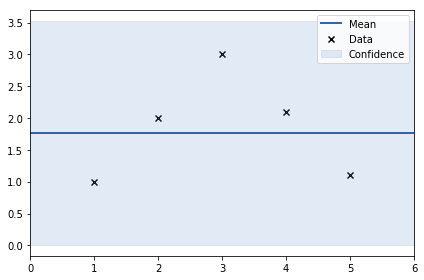

In [3]:
X = np.array([1, 2, 3, 4, 5]).reshape(-1, 1)
y = np.array([1, 2, 3, 2.1, 1.1]).reshape(-1, 1) 


ell_1 = 2.
sf  = 1.5**2
sn  = 1.2**2

k = GPy.kern.Bias(1, variance=sn) + LinScaleShift(1, variances=sf, shifts=ell_1)

gpml_result = np.array([
    [3.69000000000000, 1.44000000000000, -0.810000000000000, -3.06000000000000, -5.31000000000000],
    [1.44000000000000, 1.44000000000000, 1.44000000000000, 1.44000000000000, 1.44000000000000],
    [-0.810000000000000, 1.44000000000000, 3.69000000000000, 5.94000000000000, 8.19000000000000],
    [-3.06000000000000, 1.44000000000000, 5.94000000000000, 10.4400000000000, 14.9400000000000],
    [-5.31000000000000, 1.44000000000000, 8.19000000000000, 14.9400000000000, 21.6900000000000]])

# Test covariance matrix correctness
cov_mat = k.K(X, X)
assert np.allclose(cov_mat, gpml_result)

m = GPy.models.GPRegression(X, y, kernel=k, noise_var=1.**2)
m.optimize_restarts(verbose=False)
m.plot()

# TODO: Test negative log marginal likelihood correctness
# gpml_nlml = ...
# assert np.isclose(gpml_nlml, -m.log_likelihood(), rtol=1e-03)